# Grafon

### Qué va a analizar nuestro grafo?

Analizar "gente que haya tenido experiencias facultativas similares" -> sacamos el factor temporal

### Qué queremos responder?

Qué electivas curso?

### Cómo es el grafo?

- Nodos: usuarios
- Aristas: cursar misma materia y "les fue parecido" -> -1 (en el final), 4-5, 6-7, 8-10
- Peso: porcentaje de similitud de materia+nota

### Dos formas de armar el análisis
- sólo correr sobre materias electivas
- correr sobre todas las materias, pero filtrar el output por electivas

### Ejemplo de conexión:

X y yo cursamos ...

In [ ]:
import pandas as pd

df = pd.read_pickle('fiuba-map-data.pickle')
df.tail(3)

,Padron,Carrera,Orientacion,Final de Carrera,materia_id,materia_nota,materia_cuatrimestre,aplazos,optativas
21323,42116191,informatica,NaN,NaN,61.03,0.0,NaN,NaN,NaN
21324,42116191,informatica,NaN,NaN,62.01,0.0,NaN,NaN,NaN
21325,42116191,informatica,NaN,NaN,75.40,0.0,NaN,NaN,NaN


In [ ]:
categories = {
    4: 0,
    5: 0,
    6: 1,
    7: 1,
    8: 2,
    9: 2,
    10: 2
}

df_rel = df[['Padron', 'materia_id', 'materia_nota']].copy()

# Sacamos materias en final y a cursar
df_rel = df_rel[df_rel['materia_nota'] >= 4]
# Sacamos gente que no le pone la nota a su fiubamap
df_rel['promedio'] = df_rel.groupby('Padron')['materia_nota'].transform('mean')
df_rel = df_rel[df_rel['promedio'] > 5]

df_rel['materia_categoria'] = df_rel['materia_nota'].apply(lambda x: categories[x])
df_simil = pd.merge(df_rel, df_rel, on=['materia_id', 'materia_categoria'])
df_simil = df_simil[df_simil['Padron_x'] != df_simil['Padron_y']]
df_simil = df_simil.reset_index()
df_simil

,index,Padron_x,materia_id,materia_nota_x,promedio_x,materia_categoria,Padron_y,materia_nota_y,promedio_y
0,1,111111,CBC28,8.0,8.142857,2,107539,8.0,7.352941
1,2,111111,CBC28,8.0,8.142857,2,102141,10.0,7.307692
2,3,111111,CBC28,8.0,8.142857,2,108441,9.0,8.000000
3,4,111111,CBC28,8.0,8.142857,2,103713,8.0,7.074074
4,5,111111,CBC28,8.0,8.142857,2,110310,9.0,7.375000
...,...,...,...,...,...,...,...,...,...
1411683,1422059,99627,75.48,7.0,7.553191,1,98338,7.0,7.317073
1411684,1422060,93445,75.48,7.0,6.974359,1,99627,7.0,7.553191
1411685,1422062,93445,75.48,7.0,6.974359,1,98338,7.0,7.317073
1411686,1422063,98338,75.48,7.0,7.317073,1,99627,7.0,7.553191


Esto resultaría en un grafo con pocos nodos y 1407892 de aristas, es decir demasiadas aristas. Por eso se busca un enfoque de unificar aristas mediante algún tipo de criterio y de esta forma tener sólo una arista entre padrones.

In [ ]:
import numpy as np

df_simil_agg = df_simil.groupby(['Padron_x', 'Padron_y']).agg(cant=('materia_id', 'count'))
df_simil_agg = df_simil_agg.reset_index()

df_simil_agg['Padron_min'] = df_simil_agg[['Padron_x', 'Padron_y']].min(axis=1)
df_simil_agg['Padron_max'] = df_simil_agg[['Padron_x', 'Padron_y']].max(axis=1)
df_simil_agg = df_simil_agg.drop_duplicates(['Padron_min', 'Padron_max']).reset_index()

df_simil_agg['inv_cant'] = df_simil_agg['cant'].max() - df_simil_agg['cant'] + 1
df_simil_agg

,index,Padron_x,Padron_y,cant,Padron_min,Padron_max,inv_cant
0,0,-1,0000,10,-1,0000,26
1,1,-1,02902,2,-1,02902,34
2,2,-1,100016,9,-1,100016,27
3,3,-1,100029,12,-1,100029,24
4,4,-1,100029asdasdasdasd,4,-1,100029asdasdasdasd,32
...,...,...,...,...,...,...,...
176526,351309,sadfsdfsdfgfasdfdsgsdfg,tplink,4,sadfsdfsdfgfasdfdsgsdfg,tplink,32
176527,351310,sadfsdfsdfgfasdfdsgsdfg,xasdasdasd,13,sadfsdfsdfgfasdfdsgsdfg,xasdasdasd,23
176528,351899,sadfsdfsdfgfdsgsdfg,tplink,4,sadfsdfsdfgfdsgsdfg,tplink,32
176529,351900,sadfsdfsdfgfdsgsdfg,xasdasdasd,13,sadfsdfsdfgfdsgsdfg,xasdasdasd,23


In [ ]:
df_simil_agg.sort_values('cant', ascending=False).head(25)

,index,Padron_x,Padron_y,cant,Padron_min,Padron_max,inv_cant
13209,13462,100687,99732,35,100687,99732,1
176212,338462,99616,99732,32,99616,99732,4
12687,12940,100687,102145,31,100687,102145,5
37616,39960,102145,102192,30,102145,102192,6
12693,12946,100687,102192,29,100687,102192,7
29058,30456,101601,102145,29,101601,102145,7
173816,310018,95897,99423,29,95897,99423,7
12066,12297,100680,101483,29,100680,101483,7
12748,13001,100687,103371,29,100687,103371,7
175126,322160,98124,98591,28,98124,98591,8


In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(df_simil_agg, 
                            source='Padron_x', 
                            target='Padron_y', 
                            edge_attr='inv_cant',
                            create_using=nx.Graph())

print(G)

Graph with 643 nodes and 176531 edges


In [ ]:
G.edges[('-1', '0000')]

{'inv_cant': 26}

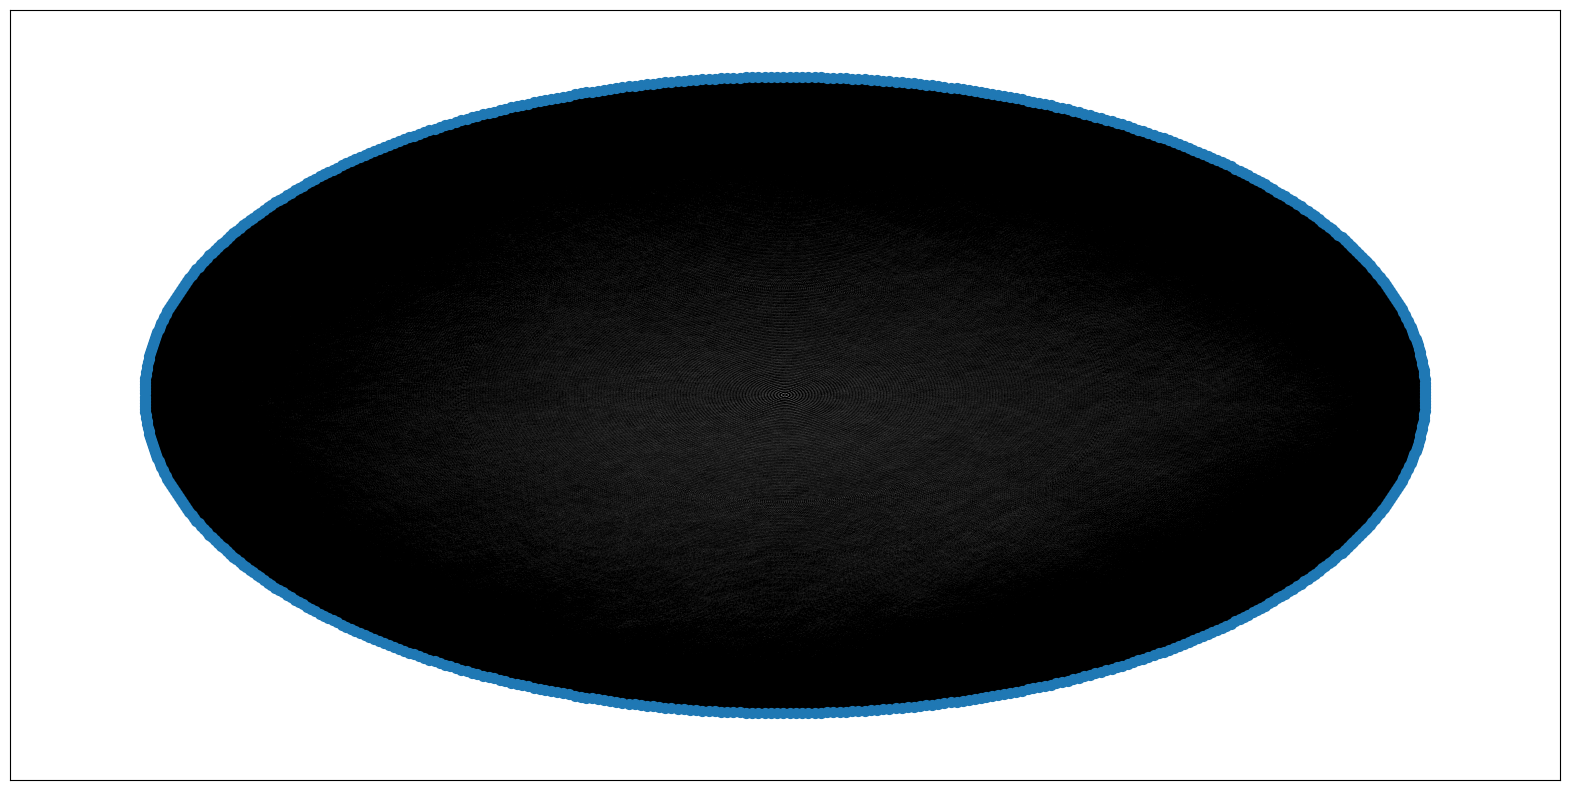

In [ ]:
# Veamos el grafo
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.circular_layout(G), width=0.005, node_size=50, with_labels=False)

## Stats generales del grafo

In [ ]:
print(f"""
  El diámetro de la red: {nx.diameter(G)}
  El grado promedio de la red: {sum([n[1] for n in G.degree()]) / len(G):.2f}
  TODO: Los allegados promedio de la red: 
  Puentes globales: {list(nx.bridges(G))}
""")


  El diámetro de la red: 3
  El grado promedio de la red: 549.09
  TODO: Los allegados promedio de la red: 
  Puentes globales: []



## Comunidades

In [ ]:
from networkx.algorithms import community
louvain = community.louvain_communities(G, weight='inv_cant', resolution=1.02)

In [ ]:
len(louvain)

17

In [ ]:
def padrones_similares(padron, resolution):
    louvain = community.louvain_communities(G, weight='inv_cant', resolution=resolution)
    return list(filter(lambda x: padron in x, louvain))[0]

def materias_padron(padron):
    return df[(df['Padron'] == padron) & (df['materia_nota'] >= 4)]['materia_id'].values

def sugerir_electivas(padron, resolution=1):
    padrones = padrones_similares(padron, resolution)
    df_sugerencias = df_rel[df_rel['Padron'].isin(padrones)].groupby('materia_id').agg(cant=('materia_id', 'count'))
    df_sugerencias = df_sugerencias[~df_sugerencias.index.isin(materias_padron(padron))]
    
    df_materias = pd.read_csv('informatica.csv')
    df_sugerencias = pd.merge(df_sugerencias, df_materias, on='materia_id')
    df_sugerencias = df_sugerencias[df_sugerencias['categoria'] == 'Materias Electivas']
    
    df_sugerencias = df_sugerencias[['materia_id', 'materia_nombre', 'creditos', 'cant']].sort_values('cant', ascending=False)
    return df_sugerencias.reset_index(drop=True)

sugerir_electivas('100687', 1.03)

,materia_id,materia_nombre,creditos,cant
0,75.29,Teoría de Algoritmos I,6,33
1,71.12,Estructura de las Organizaciones,6,32
2,71.18,Estructura Económica Argentina,4,19
3,75.71,Seminario de Ingeniería en Informática I,3,12
4,75.50,Introducción a los Sistemas Inteligentes,6,9
5,66.71,Sistemas Gráficos,6,9
6,66.09,Laboratorio de Microcomputadoras,6,6
7,75.69,Sistemas Automáticos de Diagnóstico y Detecció...,6,6
8,66.74,Señales y Sistemas,6,6
9,75.30,Teoría de Algoritmos II,6,6
